In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
import sys
sys.path.append(os.getenv('PYTHONPATH'))
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import pickle
import hcp_utils as hcp
from nilearn import plotting
import json
import pandas as pd
import seaborn as sns
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

#local imports
from src.utils.transforms import SelectROIs
from src.utils.helpers import FilterDataset, vectorized_correlation
from src.utils.dataset import FMRIDataset

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [11]:
def plot_flatmap(stat, title="", cmap='hot'):
    #Save flat maps. hemispheres are combined in one plot
    #get the data for both hemispheres
    cortex_data_left = hcp.left_cortex_data(stat)
    cortex_data_right = hcp.right_cortex_data(stat)

    #determine global min/max for consistent color scaling
    datamin = min(np.nanmin(cortex_data_left), np.nanmin(cortex_data_right))
    datamax = max(np.nanmax(cortex_data_left), np.nanmax(cortex_data_right))
    vmin=datamin
    vmax=datamax
    threshold = None

    #create a figure with multiple axes to plot each anatomical image
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), subplot_kw={'projection': '3d'})
    plt.subplots_adjust(wspace=0)
    im = plotting.plot_surf(hcp.mesh.flat_left, cortex_data_left,
            threshold=threshold, bg_map=hcp.mesh.sulc_left, 
            colorbar=False, cmap=cmap,
            axes = axes[0])
    im = plotting.plot_surf(hcp.mesh.flat_right, cortex_data_right,
            threshold=threshold, bg_map=hcp.mesh.sulc_right, 
            colorbar=False, cmap=cmap,
            axes = axes[1])
    
    #flip along the horizontal
    axes[0].invert_yaxis()
    axes[1].invert_yaxis()

    #create colorbar
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), shrink=0.6)
    plt.title(title)
    #cbar.set_ticks([0, round(datamax), 100])
    #cbar.set_ticklabels([0, round(datamax), 100])
    plt.show()
    plt.close()

In [3]:
project_root = os.getenv("PROJECT_ROOT", "/default/path/to/datasets") #use default if DATASETS_ROOT env variable is not set.
dataset_root = os.path.join(os.getenv("DATASETS_ROOT", "/default/path/to/datasets"), "MOSAIC") #use default if DATASETS_ROOT env variable is not set.


In [4]:
#load test jsons
with open(os.path.join(dataset_root, 'test_naturalistic.json'), 'r') as f:
    test_naturalistic_all = json.load(f)
with open(os.path.join(dataset_root, 'test_artificial.json'), 'r') as f:
    test_artificial_all = json.load(f)

test_naturalistic_Dataset = FilterDataset(dataset_include=['NSD','deeprecon'])
test_naturalistic_all_filtered, mapping_naturalistic = test_naturalistic_Dataset.filter_splits(test_naturalistic_all)
test_naturalistic_stimuli = test_naturalistic_Dataset.get_stimulus_filenames(test_naturalistic_all_filtered)

test_artificial_Dataset = FilterDataset(dataset_include=['NSD','deeprecon'])
test_artificial_all_filtered, mapping_artificial = test_artificial_Dataset.filter_splits(test_artificial_all)
test_artificial_stimuli = test_artificial_Dataset.get_stimulus_filenames(test_artificial_all_filtered)

all_subjects = sorted(list(set(list(mapping_naturalistic.keys()) + list(mapping_artificial.keys()))))

print(all_subjects)

rois = [f"GlasserGroup_{x}" for x in range(1,6)]
ROI_selection = SelectROIs(selected_rois=rois)
NSDsubjects = [f"sub-{x:02}_NSD" for x in [1,2,5,7]] #[f"sub-{x:02}_NSD" for x in range(1,9)]

['sub-01_NSD', 'sub-01_deeprecon', 'sub-02_NSD', 'sub-02_deeprecon', 'sub-03_NSD', 'sub-03_deeprecon', 'sub-04_NSD', 'sub-05_NSD', 'sub-06_NSD', 'sub-07_NSD', 'sub-08_NSD']


In [5]:
dataset = FMRIDataset(None, ROI_selection, use_noiseceiling=True, trial_selection='average', fmri_transforms=None)

fmri_all = defaultdict(dict)
noiseceilings_all = defaultdict()
phase = 'test'
for subjectID in all_subjects:
    DatasetFilter = FilterDataset(subject_include=[subjectID])
    sample = dataset.load_responses_block_hdf5(subjectID, verbose=True) #loads all fmri responses for that subjectID in a dictionary and averaging trials if specified in FMRIDataset instance initialization
    stimuli = sample['stimulus_filename'] #get all the stimuli viewed by that subjectID
    #get the filenames that we are going to evaluate on. For within-subject, these filenames are the 'imitated_subjectID''s test set
    for task in ['naturalistic', 'artificial']:
        if task == 'artificial' and subjectID.split('_')[-1] not in ['NSD', 'deeprecon']:
            continue
        if task == 'naturalistic':
            json_dataset = test_naturalistic_all
            phase = 'test'
        elif task == 'artificial':
            json_dataset = test_artificial_all
            phase = 'artificial'
        filtered_json, _ = DatasetFilter.filter_splits(json_dataset) #filter the json file by the subject you are including
        desired_stimuli_tmp = DatasetFilter.get_stimulus_filenames(filtered_json)
        #remove extension
        desired_stimuli = set([Path(s).stem for s in desired_stimuli_tmp]) #undordered but constant time indexing
        
        fmri_tmp = np.full((len(desired_stimuli), len(ROI_selection.selected_roi_indices)), np.nan)
        stimuli_tmp = [] #keep track of the order of the betas
        idx = 0
        for orig_idx, stim in enumerate(stimuli):
            if stim in desired_stimuli:
                fmri_tmp[idx,:] = sample['fmri'][orig_idx,:]
                stimuli_tmp.append(stim)
                idx += 1
        
        fmri_all[f"{subjectID}_{task}"] = {'betas': fmri_tmp, 'stimuli': stimuli_tmp}
        #we use the n-avg noiseceilings here because the model was trained on averaged trials
        noiseceilings_all[f"{subjectID}_{task}"] = sample['noiseceiling'][f"{subjectID}_phase-{phase}_n-avg"] + 1e-10 #noiseceiling is already divided by 100 and indexed for ROI vertices 


loading betas...


loading betas for subject sub-01_NSD: 100%|██████████| 10284/10284 [00:13<00:00, 786.60it/s]


loading betas...


loading betas for subject sub-01_deeprecon: 100%|██████████| 1300/1300 [00:00<00:00, 2081.15it/s]


loading betas...


loading betas for subject sub-02_NSD: 100%|██████████| 10284/10284 [00:12<00:00, 825.07it/s]


loading betas...


loading betas for subject sub-02_deeprecon: 100%|██████████| 1300/1300 [00:00<00:00, 2079.95it/s]


loading betas...


loading betas for subject sub-03_NSD: 100%|██████████| 9695/9695 [00:09<00:00, 993.40it/s] 


loading betas...


loading betas for subject sub-03_deeprecon: 100%|██████████| 1300/1300 [00:00<00:00, 1949.25it/s]


loading betas...


loading betas for subject sub-04_NSD: 100%|██████████| 9493/9493 [00:08<00:00, 1094.79it/s]


loading betas...


loading betas for subject sub-05_NSD: 100%|██████████| 10284/10284 [00:12<00:00, 810.28it/s]


loading betas...


loading betas for subject sub-06_NSD: 100%|██████████| 9695/9695 [00:09<00:00, 972.02it/s] 


loading betas...


loading betas for subject sub-07_NSD: 100%|██████████| 10284/10284 [00:13<00:00, 782.26it/s]


loading betas...


loading betas for subject sub-08_NSD: 100%|██████████| 9493/9493 [00:09<00:00, 1013.14it/s]


In [6]:
cols = ['correlation', 'normalized_correlation', 'prediction_subjectID', 'target_subjectID', 'task']
results = {col: [] for col in cols}
for task in ['naturalistic', 'artificial']:
    for target_subjectID in NSDsubjects:
        noiseceiling = noiseceilings_all[f'{target_subjectID}_{task}']
        for prediction_subjectID in NSDsubjects:
            if prediction_subjectID == target_subjectID:
                continue
            corr = vectorized_correlation(fmri_all[f"{prediction_subjectID}_{task}"]['betas'], fmri_all[f"{target_subjectID}_{task}"]['betas'], axis=0) #per vertex
            corr[corr<0] = 0
            normalized_corr = (corr**2)/noiseceilings_all[f"{target_subjectID}_{task}"] #noiseceiling has units of %explainable variance
            normalized_corr[normalized_corr>1] = 1 #cap at 1. per vertex

            results['correlation'].append(np.median(corr))
            results['normalized_correlation'].append(np.median(normalized_corr))
            results['task'].append(task)
            results['prediction_subjectID'].append(prediction_subjectID)
            results['target_subjectID'].append(target_subjectID)


In [7]:
df = pd.DataFrame(results)

/data/vision/oliva/blahner/anaconda3/envs/MOSAIC/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/data/vision/oliva/blahner/anaconda3/envs/MOSAIC/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/data/vision/oliva/blahner/anaconda3/envs/MOSAIC/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


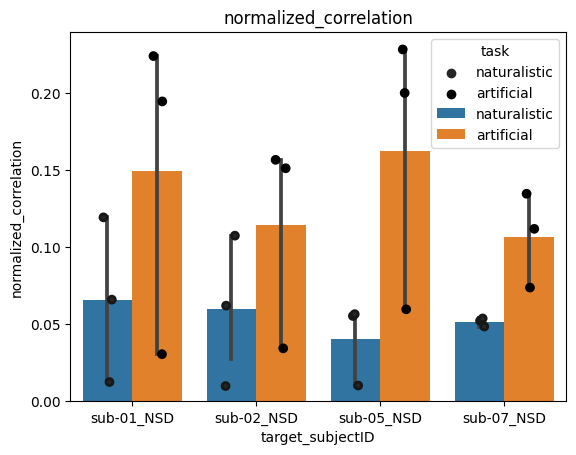

In [9]:
ycol = 'normalized_correlation'
sns.barplot(data=df, x='target_subjectID', y=ycol, hue='task')
sns.stripplot(data=df, x='target_subjectID', y=ycol, hue='task', dodge=True, linewidth=2, color='black')
plt.title(f"{ycol}")
plt.show()

In [20]:
a = fmri_all['sub-01_NSD_naturalistic']['betas']
b = fmri_all['sub-02_NSD_naturalistic']['betas']

In [21]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr

def compute_rdm_correlation(matrix1, matrix2):
    """
    Compute RDMs for two matrices using cosine distance, then calculate
    Spearman correlation between the RDMs.
    
    Parameters:
    -----------
    matrix1 : numpy.ndarray
        First matrix of shape (n_samples, n_features_1)
    matrix2 : numpy.ndarray
        Second matrix of shape (n_samples, n_features_2)
        
    Returns:
    --------
    rdm1 : numpy.ndarray
        RDM for matrix1 (shape: n_samples × n_samples)
    rdm2 : numpy.ndarray
        RDM for matrix2 (shape: n_samples × n_samples)
    correlation : float
        Spearman correlation coefficient between the two RDMs
    p_value : float
        p-value for the correlation
    """
    # Check that both matrices have the same number of samples
    if matrix1.shape[0] != matrix2.shape[0]:
        raise ValueError("Both matrices must have the same number of samples (rows)")
    
    # Compute pairwise cosine distances for each matrix
    rdm1 = squareform(pdist(matrix1, metric='cosine'))
    rdm2 = squareform(pdist(matrix2, metric='cosine'))
    
    # Convert the RDMs to vectors (taking only the upper triangular part, excluding diagonal)
    # This avoids counting the same pair twice and the self-comparisons (diagonal)
    vec1 = rdm1[np.triu_indices_from(rdm1, k=1)]
    vec2 = rdm2[np.triu_indices_from(rdm2, k=1)]
    
    # Compute Spearman correlation between the two vectors
    correlation, p_value = spearmanr(vec1, vec2)
    
    return rdm1, rdm2, correlation, p_value

In [26]:
rdm1, rdm2, corr, p_val = compute_rdm_correlation(fmri_all['sub-01_NSD_naturalistic']['betas'], fmri_all['sub-07_NSD_naturalistic']['betas'])
print(f"corr: {corr}, p_val: {p_val}")

corr: 0.21026977161495752, p_val: 0.0


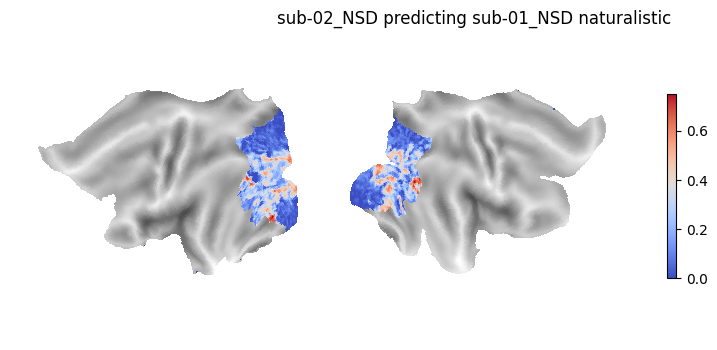

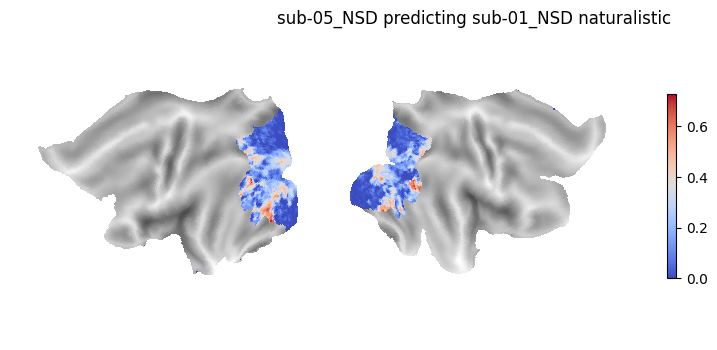

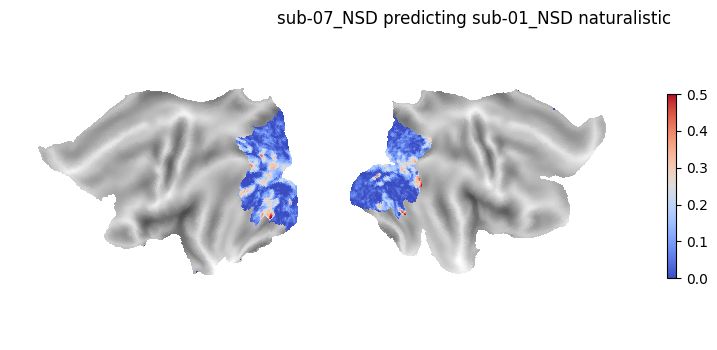

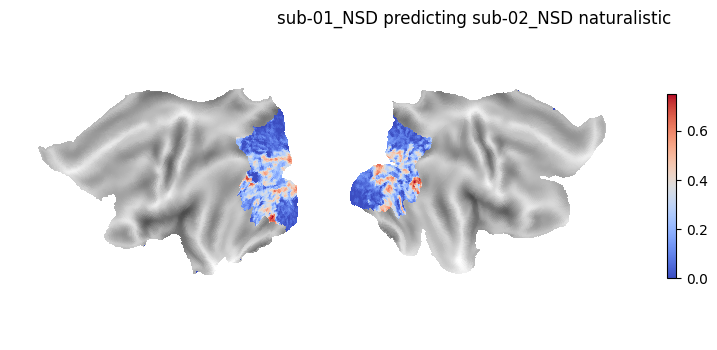

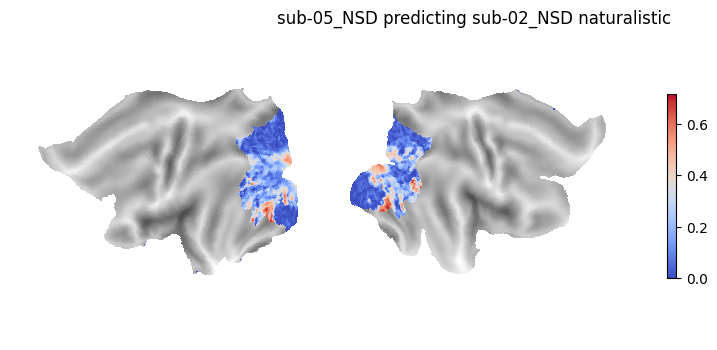

KeyboardInterrupt: 

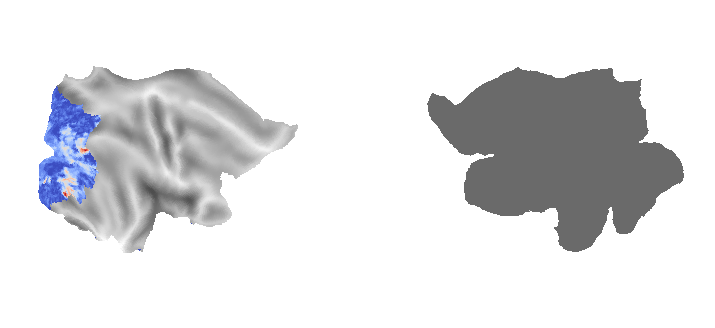

In [19]:
ycol = 'correlation'
task = 'naturalistic'
for target_subjectID in NSDsubjects:
    noiseceiling = noiseceilings_all[f'{target_subjectID}_{task}']
    for prediction_subjectID in NSDsubjects:
        if prediction_subjectID == target_subjectID:
            continue
        corr = vectorized_correlation(fmri_all[f"{prediction_subjectID}_{task}"]['betas'], fmri_all[f"{target_subjectID}_{task}"]['betas'], axis=0) #per vertex
        corr[corr<0] = 0
        normalized_corr = (corr**2)/noiseceilings_all[f"{target_subjectID}_{task}"] #noiseceiling has units of %explainable variance
        normalized_corr[normalized_corr>1] = 1 #cap at 1. per vertex

        if ycol == 'normalized_correlation':
            stat = ROI_selection.sample2wb(normalized_corr)
        elif ycol == 'correlation':
            stat = ROI_selection.sample2wb(corr)
        plot_flatmap(stat, title=f"{prediction_subjectID} predicting {target_subjectID} {task}", cmap='coolwarm')
